#Train StyleGAN_NADA

##Required downloads

In [1]:
# Cloning StyleGAN-NADA repository
!git clone https://github.com/uko3/StyleGAN-nada.git
# Installing required libraries
!pip install Ninja
!pip install git+https://github.com/openai/CLIP.git -q
%cd StyleGAN-nada

Cloning into 'StyleGAN-nada'...
remote: Enumerating objects: 320, done.
remote: Counting objects: 100% (91/91), done.
remote: Compressing objects: 100% (70/70), done.
remote: Total 320 (delta 49), reused 57 (delta 21), pack-reused 229 (from 1)
Receiving objects: 100% (320/320), 17.51 MiB | 20.70 MiB/s, done.
Resolving deltas: 100% (176/176), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/2

In [2]:
# Importing modules
import torch
import torch.optim as optim
from torchvision.utils import save_image
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import math
import copy
import re
import warnings
import clip
warnings.filterwarnings("ignore")

# Importing custom modules
from modules.stylegan_arch.model import Generator
from modules.losses import CLIPLoss, CLIPDirectionalLoss
from modules.trainer import LatentStyleTrainer
from modules.utils import generate_visualize_and_save
from modules.freeze_layers import freeze_layers_adaptive

# Selecting device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")

Используется устройство: cuda


In [3]:
# Downloading pretrained StyleGAN2 model
if not os.path.exists('stylegan2-ffhq-config-f.pt'):
    !gdown https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT -O stylegan2-ffhq-config-f.pt

# StyleGAN parameters
size = 1024
latent_dim = 512
n_mlp = 8
channel_multiplier = 2
ckpt_path = 'stylegan2-ffhq-config-f.pt'

# Loading generator
generator = Generator(size, latent_dim, n_mlp, channel_multiplier=channel_multiplier).to(device)
generator.eval()
checkpoint = torch.load(ckpt_path)
generator.load_state_dict(checkpoint["g_ema"])

Downloading...
From (original): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT
From (redirected): https://drive.google.com/uc?id=1EM87UquaoQmk17Q8d5kYIAHqu0dkYqdT&confirm=t&uuid=0f99805e-5f78-423a-8855-4360477f4500
To: /content/StyleGAN-nada/stylegan2-ffhq-config-f.pt
100% 381M/381M [00:03<00:00, 119MB/s]


<All keys matched successfully>

In [4]:
# Loading CLIP model
model_clip, preprocess = clip.load('ViT-B/32', device)

100%|███████████████████████████████████████| 338M/338M [00:06<00:00, 52.7MiB/s]


##Defining transformation classes

In [5]:
source_class = "photo" # Source description
target_class = "sketch" # Target description
text_source = clip.tokenize([source_class]).to(device)
text_target = clip.tokenize([target_class]).to(device)

with torch.no_grad():
    text_features_source = model_clip.encode_text(text_source)
    text_features_target = model_clip.encode_text(text_target)
text_features_source = text_features_source / text_features_source.norm(dim=-1, keepdim=True)
text_features_target = text_features_target / text_features_target.norm(dim=-1, keepdim=True)
sim = torch.nn.functional.cosine_similarity(text_features_target, text_features_source)
print(f"Text sim: {sim.item():.4f}")

# CLIP Directional loss function
clip_directional_loss_fn = CLIPDirectionalLoss()


Text sim: 0.8921


##Training

[1/60] Loss: 0.6600 | CLIP: 0.9521 | L2: 0.0000 [2/60] Loss: 0.5479 | CLIP: 0.9072 | L2: 0.0052 [3/60] Loss: 0.4923 | CLIP: 0.9312 | L2: 0.0164 [4/60] Loss: 0.4010 | CLIP: 0.9048 | L2: 0.0052 [5/60] Loss: 0.3443 | CLIP: 0.9004 | L2: 0.0121 [6/60] Loss: 0.2820 | CLIP: 0.8730 | L2: 0.0081 [7/60] Loss: 0.2258 | CLIP: 0.8140 | L2: 0.0126 [8/60] Loss: 0.1914 | CLIP: 0.8081 | L2: 0.0139 [9/60] Loss: 0.1809 | CLIP: 0.8940 | L2: 0.0156 [10/60] Loss: 0.1445 | CLIP: 0.8325 | L2: 0.0161 

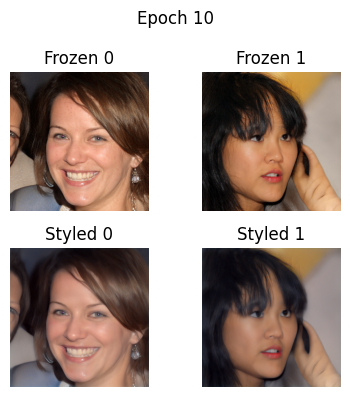

[11/60] Loss: 0.1218 | CLIP: 0.8110 | L2: 0.0193 [12/60] Loss: 0.1155 | CLIP: 0.8730 | L2: 0.0333 [13/60] Loss: 0.1005 | CLIP: 0.8667 | L2: 0.0401 [14/60] Loss: 0.0792 | CLIP: 0.7939 | L2: 0.0311 [15/60] Loss: 0.0724 | CLIP: 0.8291 | L2: 0.0324 [16/60] Loss: 0.0652 | CLIP: 0.8550 | L2: 0.0289 [17/60] Loss: 0.0584 | CLIP: 0.8301 | L2: 0.0561 [18/60] Loss: 0.0499 | CLIP: 0.8027 | L2: 0.0510 [19/60] Loss: 0.0450 | CLIP: 0.8154 | L2: 0.0470 [20/60] Loss: 0.0431 | CLIP: 0.8330 | L2: 0.0823 

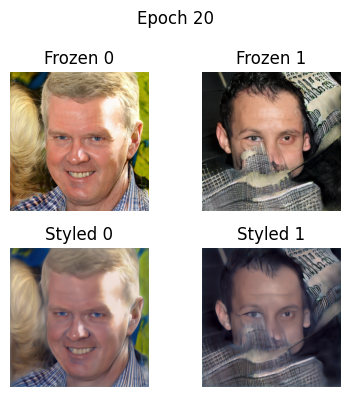

[21/60] Loss: 0.0371 | CLIP: 0.8350 | L2: 0.0408 [22/60] Loss: 0.0322 | CLIP: 0.7720 | L2: 0.0654 [23/60] Loss: 0.0309 | CLIP: 0.8096 | L2: 0.0702 [24/60] Loss: 0.0295 | CLIP: 0.8477 | L2: 0.0681 [25/60] Loss: 0.0264 | CLIP: 0.8340 | L2: 0.0531 [26/60] Loss: 0.0237 | CLIP: 0.7969 | L2: 0.0709 [27/60] Loss: 0.0218 | CLIP: 0.7905 | L2: 0.0674 [28/60] Loss: 0.0207 | CLIP: 0.7939 | L2: 0.0842 [29/60] Loss: 0.0193 | CLIP: 0.7944 | L2: 0.0770 [30/60] Loss: 0.0180 | CLIP: 0.7559 | L2: 0.1289 

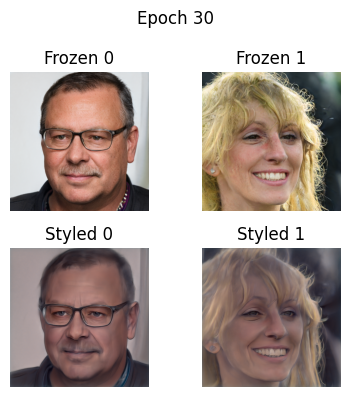

[31/60] Loss: 0.0175 | CLIP: 0.8154 | L2: 0.0707 [32/60] Loss: 0.0168 | CLIP: 0.7915 | L2: 0.1396 [33/60] Loss: 0.0152 | CLIP: 0.7930 | L2: 0.0628 [34/60] Loss: 0.0150 | CLIP: 0.7822 | L2: 0.1446 [35/60] Loss: 0.0131 | CLIP: 0.7344 | L2: 0.0956 [36/60] Loss: 0.0139 | CLIP: 0.8232 | L2: 0.0866 [37/60] Loss: 0.0128 | CLIP: 0.7852 | L2: 0.0953 [38/60] Loss: 0.0120 | CLIP: 0.7725 | L2: 0.0857 [39/60] Loss: 0.0118 | CLIP: 0.7686 | L2: 0.1317 [40/60] Loss: 0.0112 | CLIP: 0.7529 | L2: 0.1355 

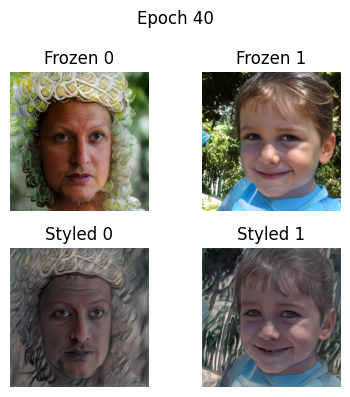

[41/60] Loss: 0.0108 | CLIP: 0.7627 | L2: 0.1187 [42/60] Loss: 0.0109 | CLIP: 0.7891 | L2: 0.1315 [43/60] Loss: 0.0100 | CLIP: 0.7632 | L2: 0.0784 [44/60] Loss: 0.0101 | CLIP: 0.7803 | L2: 0.1305 [45/60] Loss: 0.0104 | CLIP: 0.8037 | L2: 0.1971 [46/60] Loss: 0.0097 | CLIP: 0.7793 | L2: 0.1639 [47/60] Loss: 0.0091 | CLIP: 0.7617 | L2: 0.1188 [48/60] Loss: 0.0096 | CLIP: 0.8135 | L2: 0.1672 [49/60] Loss: 0.0090 | CLIP: 0.7910 | L2: 0.1512 [50/60] Loss: 0.0082 | CLIP: 0.7490 | L2: 0.0970 

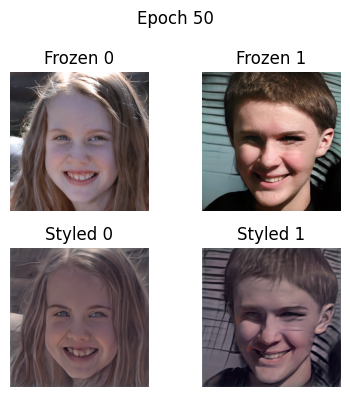

[51/60] Loss: 0.0084 | CLIP: 0.7744 | L2: 0.1423 [52/60] Loss: 0.0085 | CLIP: 0.7812 | L2: 0.1863 [53/60] Loss: 0.0084 | CLIP: 0.7988 | L2: 0.1620 [54/60] Loss: 0.0080 | CLIP: 0.7905 | L2: 0.1089 [55/60] Loss: 0.0081 | CLIP: 0.8130 | L2: 0.1392 [56/60] Loss: 0.0077 | CLIP: 0.7930 | L2: 0.1170 [57/60] Loss: 0.0075 | CLIP: 0.7842 | L2: 0.1028 [58/60] Loss: 0.0071 | CLIP: 0.7539 | L2: 0.1078 [59/60] Loss: 0.0072 | CLIP: 0.7617 | L2: 0.1650 [60/60] Loss: 0.0072 | CLIP: 0.7910 | L2: 0.0983 

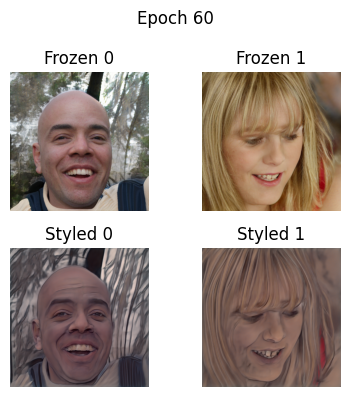

In [6]:
# Training parameters
epochs_to_train = 60
top_k = 10
torch.manual_seed(43)
trainer = LatentStyleTrainer(
    generator=generator,
    model_clip=model_clip,
    text_features_source=text_features_source,
    text_features_target=text_features_target,
    freeze_fn=lambda model_train, model_frozen, text, top_k: freeze_layers_adaptive(model_train, model_frozen, text, k=top_k),
    clip_directional_loss=clip_directional_loss_fn,
    latent_dim=latent_dim,
    batch_size=2,
    device=device,
    lr_generator=0.008,
    lr_lambda=0.2,
    weight_decay=0.003,
    scheduler_step_size=40,
    scheduler_gamma=0.3
)
# Training
trainer.train(epochs=epochs_to_train, freeze_each_epoch=True, reclassify=False)

##Visualizing style

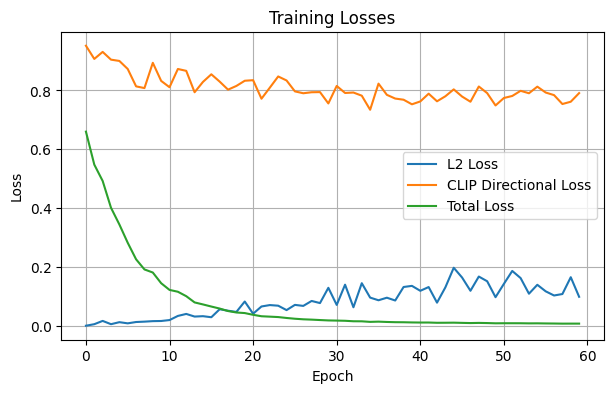

In [7]:
# Plotting losses
trainer.plot_losses()

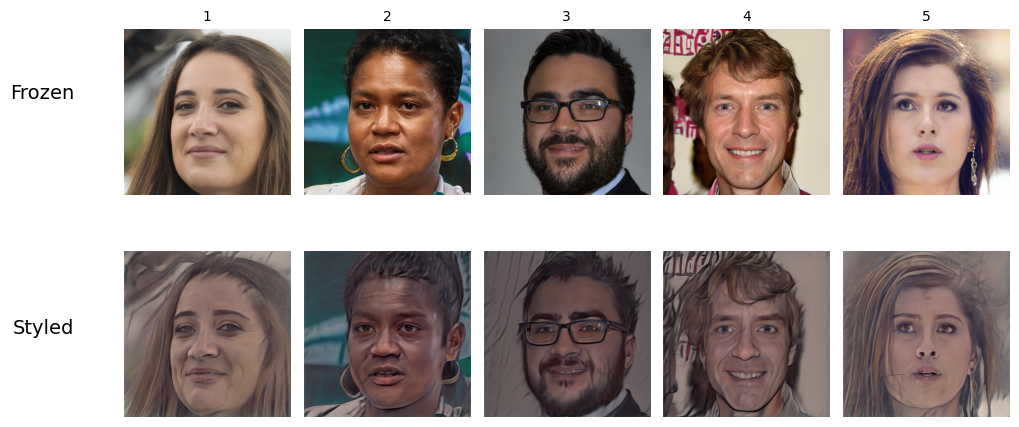

Saved styled images to: ../validation_outputs/sketch


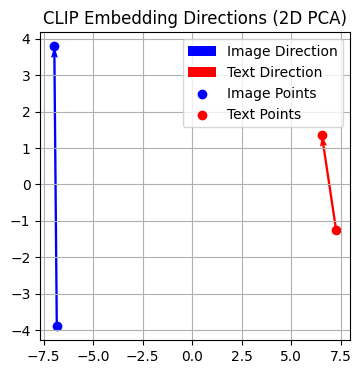

In [8]:
# Generating test images
seeds = (92126, 773, 779, 373, 2112)
generate_visualize_and_save(trainer, seeds, output_dir="../validation_outputs", folder_name="sketch")

# Visualizing style direction
latent_w_vis = trainer.sample_latent_w(seed=seeds[0])
image_frozen_vis, _ = trainer.model["generator_frozen"]([latent_w_vis], input_is_latent=True, randomize_noise=False)
image_styled_vis, _ = trainer.model["generator_train"]([latent_w_vis], input_is_latent=True, randomize_noise=False)
trainer.visualize_clip_directions(image_frozen=image_frozen_vis, image_styled=image_styled_vis,
                                  text_target=text_target, text_source=text_source, preprocess=preprocess)

##Saving trained model

In [9]:
# Saving trained model
output_model_path = "pretrained_models/"+target_class+".pth"
os.makedirs(os.path.dirname(output_model_path), exist_ok=True) # Create the directory if it doesn't exist
trainer.model["generator_train"].eval()
torch.save(trainer.model["generator_train"].state_dict(), output_model_path)
print(f"Model saved to: StyleGAN-nada/{output_model_path}")

Model saved to: StyleGAN-nada/pretrained_models/sketch.pth
